In [1]:
%run "../../../common/0_notebooks_base_setup.py"   

/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_49/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
nltk=3.5 already installed
unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


<img src='../../../common/logo_DH.png' align='left' width=35%/>

# Series de Tiempo - Checkpoint

<br/> 

<div id="caja11" style="float:left;width: 100%;">
  <div style="float:left;width: 9%;"><img src="../../../common/icons/haciendo_foco.png" style="align:left"/> </div>
  <br>
  <div style="float:left;width: 85%;">
      <label>Vamos a poner en práctica lo aprendido en la notebook de práctica guiada.</label>
  <div style="float:left;width: 85%;">
      <label>Es importante que antes de la clase resuelvan esta notebook ya que es fundamental que sepan utilizar las herramientas que vimos en la práctica guiada para después trabajar el caso práctico en la clase.</label>        
</div>    
</div>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

# from checkpoint_series_tiempo import *

#### Vamos a recrear la serie que hicimos la clase pasada. Y luego le aplicaremos el modelo ARIMA

La serie que usamos es el precio de la cebolla en India.

La preparamos para generar los modelos.

In [3]:
df = pd.read_csv('../Data/cebolla_india.csv')
df['date'] = pd.to_datetime(df['date'])

# Solo la ciudad de Bangalore
dfBang = df.loc[df.city == 'BANGALORE'].copy()

dfBang = dfBang.sort_values(by = "date")  
dfBang.index = pd.PeriodIndex(dfBang.date, freq='M')

# Dummy de tiempo
dfBang["timeIndex"] = pd.Series(np.arange(len(dfBang['priceMod'])), index=dfBang.index)

# Creamos las dummies de mes
dummies_mes = pd.get_dummies(dfBang['month'], drop_first=True)
dfBang =  dfBang.join(dummies_mes)
dfBang.tail(3)

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,...,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,,,,,,,,
2015-12,BANGALORE,December,2015,513186,217,2030,1343,KNT,BANGALORE,2015-12-01,...,1,0,0,0,0,0,0,0,0,0
2016-01,BANGALORE,January,2016,507223,200,1943,1448,KNT,BANGALORE,2016-01-01,...,0,0,1,0,0,0,0,0,0,0
2016-02,BANGALORE,February,2016,400359,200,1505,1101,KNT,BANGALORE,2016-02-01,...,0,1,0,0,0,0,0,0,0,0


Vamos a definir una función que plotea series de tiempo:

In [4]:
# Función que plotea la serie:
def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Valor', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

Vamos a trabajar usando la serie **priceMod** (Precio modal).

Usá la función que acabamos de definir para plotear 'priceMod'. Recordá que las x tienen que tener un formato de datetime. 

In [10]:
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,...,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01,...,0,0,1,0,0,0,0,0,0,0
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01,...,0,1,0,0,0,0,0,0,0,0
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01,...,0,0,0,0,0,1,0,0,0,0
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01,...,0,0,0,0,0,0,0,0,0,0
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01,...,0,0,0,0,0,0,1,0,0,0


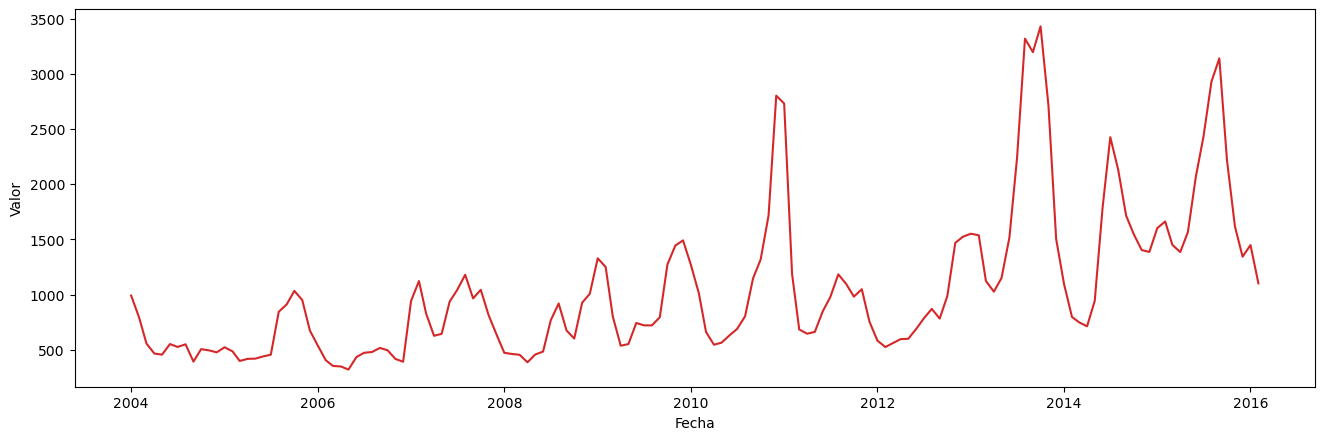

In [12]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
plot_df(dfBang,  x=dfBang.date, y=dfBang.priceMod)

Creamos los datasets de train y test con `shuffle = False`, para que no se mezclen las observaciones,y sean consecutivos con las fechas.

In [13]:
df_train, df_test = train_test_split(dfBang, test_size=12, random_state=42, shuffle=False)

Creá las transformaciones logarítmicas de priceMod tanto para el set de entrenamiento como para el set de testeo.

In [17]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:

df_train['log_priceMod'] = np.log(df_train.priceMod)
df_test['log_priceMod']  = np.log(df_test.priceMod)

Ploteá la serie logarítmica:

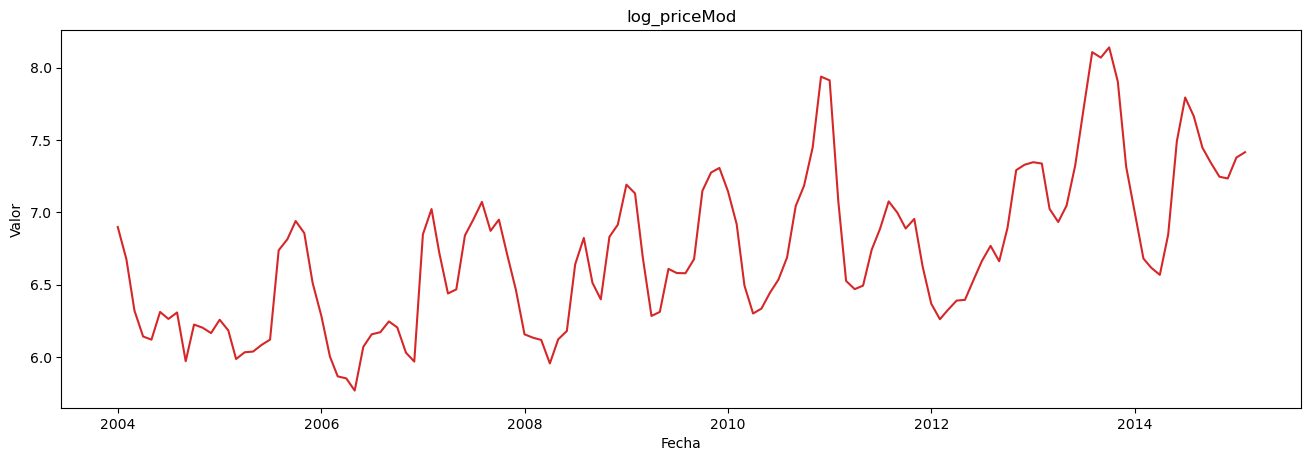

In [21]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
plot_df(df_train,  x=df_train.date, y=df_train.log_priceMod, title='log_priceMod')

Ahora entrená un modelo de transformación logaritmica con estacionalidad mensual.

In [22]:
model_log_est = smf.ols('log_priceMod ~ timeIndex + August + December + February + January + July + November+ October + September',\
                         data = df_train).fit()

# Recordá que tenés que agregar a la función de regresión los nombres de las dummies
# mensuales que agregamos antes. Recordá también que dropeamos un mes, por lo cual no lo 
# tenés que incluir en la expresión de la regresión. 
# En la solución no estamos incluyendo a los meses de junio, marzo y mayo porque no
# son significativos.

Hacé las predicciones en el set de entrenamiento y test y almacená los resultados en ambos DataFrames:

In [23]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex",\
                                              "August", "December", "February", "January",\
                                               "July","November", "October", "September"]])


df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex",\
                                              "August", "December", "February", "January",\
                                               "July","November", "October", "September"]])


Comentario: recordá que para hacer back transformation de una transformación logarítmica tenés que usar la función exponencial. 

Almacená en tus DataFrames los modelos con back transformation. 

In [24]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:

df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
df_test['back_model_log_est']  = np.exp(df_test['model_log_est'])

Creamos la función para calcular el RMSE:

In [25]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

Guardá el resultado en un DataFrame:

In [26]:
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Log + Est"
df_Results.loc[0, "RMSE"] = RMSE(df_test.back_model_log_est, df_test['priceMod'])
df_Results

,Model,RMSE
0,Log + Est,702.169


### ARIMA

---
A partir de ahora vamos a trabajar para generar un modelo ARIMA.

Calculá el resíduo del último modelo, plotealo y realizá el test ADF. Evaluá en primer lugar si el residuo de la serie original y el modelo con back transformation es estacionario. Si lo es, podés trabajar con los ciclos directamente con esa serie.

In [32]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
residuo_log_est = df_train['log_priceMod'] - df_train['model_log_est']
df_train['residuo_log_est']=residuo_log_est

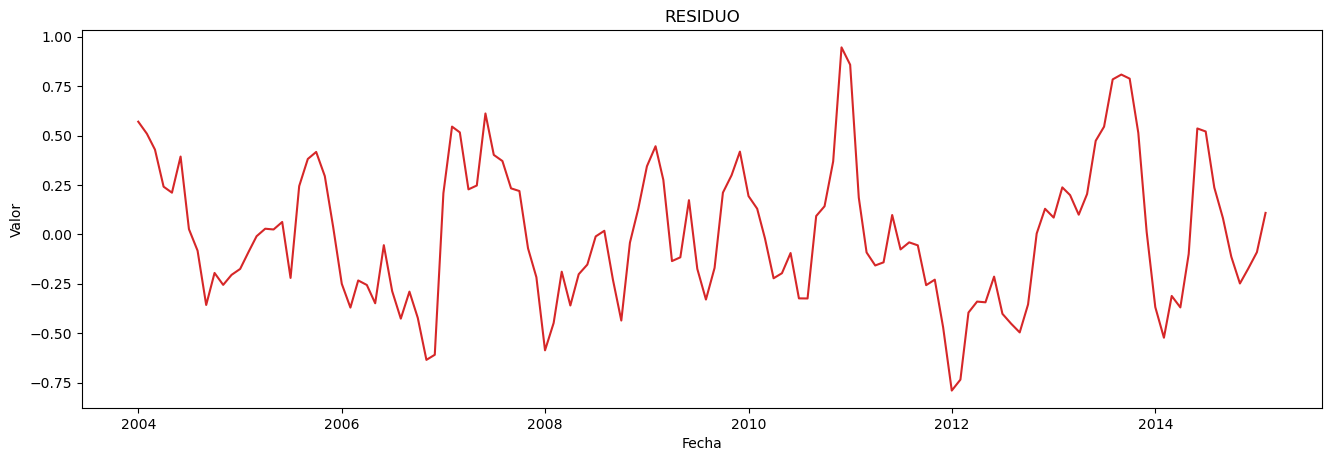

In [33]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
plot_df(df_train,  x=df_train.date, y=df_train.residuo_log_est, title='RESIDUO')

---
Vamos a definir una función que va a plotear una serie y nos va a dar información sobre su estacionariedad y sobre sus ACF y PACF:

In [34]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

Ejecutá esta función con el residuo del modelo Log+Est y 36 lags:

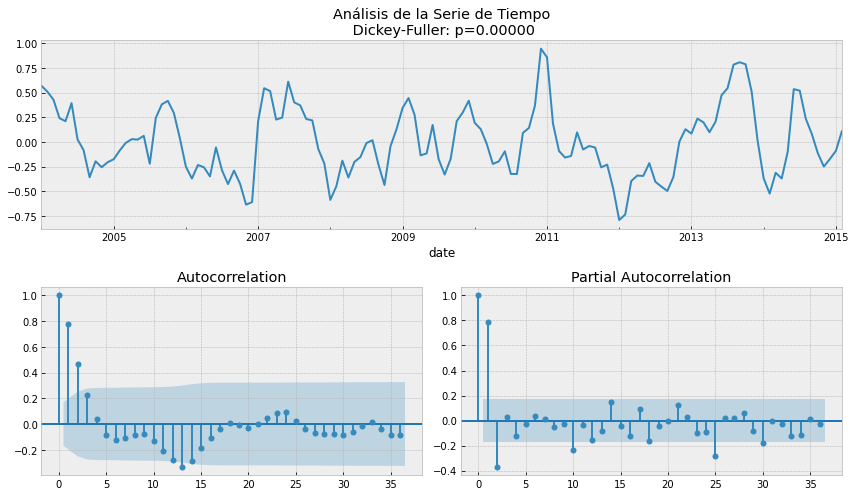

In [37]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
tsplot(residuo_log_est, lags=36, figsize=(12, 7), style='bmh')

Corré un modelo ARIMA(p,d,q) según los resultados del gráfico. ¿Cuáles van a ser los valores de p, d y q?

In [52]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:

# Comentario de la solución:
# La serie ya es estacionaria, por lo que no es necesario diferenciarla. Por lo tanto d=0.

# La función de autocorrelación ACF cae en forma exponencial.
# Esto sugiere que la componente de medias móviles es un MA(0). Por lo tanto q=0

# La PACF tiene 2 rezagos significativamente diferentes a cero.
# Esto sugiere que la componente de autoregresiva es un AR(2). Por lo tanto p=2


# Estimo el modelo:
model_ARIMA = ARIMA(residuo_log_est, order=(2,0,0))
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head()

date
2004-01    0.008258
2004-02    0.450747
2004-03    0.341111
2004-04    0.276899
2004-05    0.104548
Freq: M, dtype: float64

Hacé un gráfico del residuo y del modelo ARIMA:

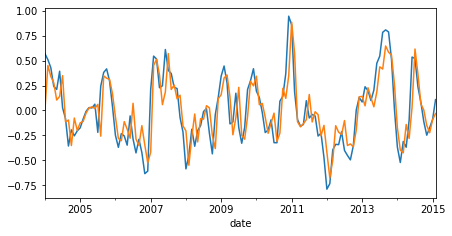

In [53]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
plt.figure(figsize=(7,3.5))
residuo_log_est.plot()
results_ARIMA.fittedvalues.plot()
plt.show()

Usá el método plot_predict() para hacer un gráfico 

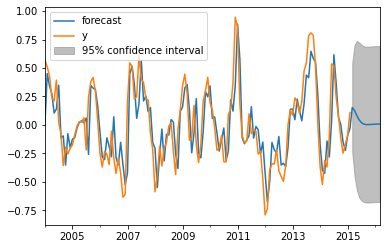

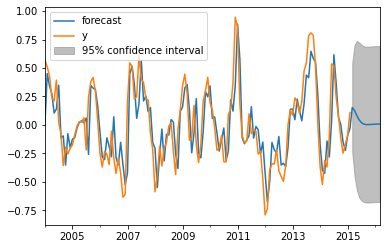

In [54]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
results_ARIMA.plot_predict(end=len(dfBang['priceMod']))

Ahora calculá el residuo de nuestro modelo ARIMA y generá los gráficos que analizan la serie de tiempo. 

In [55]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:

res_ARIMA =  results_ARIMA.fittedvalues - residuo_log_est

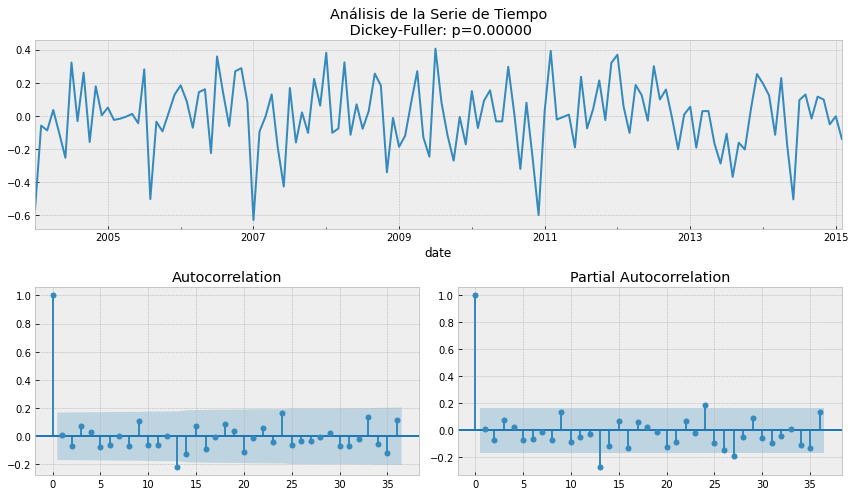

In [56]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:

# Vas a ver que no quedan más valores significativmante diferentes a cero en la 
# función de autocorrelación ni en la función de autocorrelación parcial.

tsplot(res_ARIMA, lags=36)

Crea las predicciones en el set de testeo con el método .forecast() del modelo estimado:

In [57]:
predictions_ARIMA, se, conf = results_ARIMA.forecast(len(df_test['priceMod']), alpha=0.05)

Agregá a los DataFrames de entrenamiento y testeo los modelos completos que incluyan el modelo con tendencia, estacionalidad y el modelo ARIMA. Después graficá la serie original y la predicción tanto en el set de entrenamiento como de testeo. 

In [60]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:

# En este caso, como ya estamos trabajando con los residuos de la serie original, no 
# es necesario hacer back transformation y podemos sumar el modelo ARIMA al 
# modelo con la tendencia y la estacionalidad.

df_train['model_ARIMA'] = df_train['back_model_log_est'] + results_ARIMA.fittedvalues
df_test['model_ARIMA'] = df_test['back_model_log_est'] + predictions_ARIMA

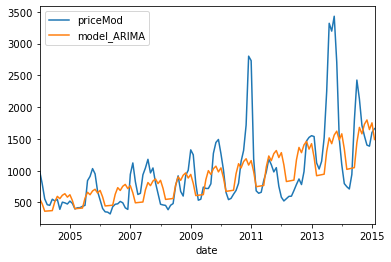

In [61]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:

df_train.plot(kind = "line", x = "date", y = ['priceMod', 'model_ARIMA']);

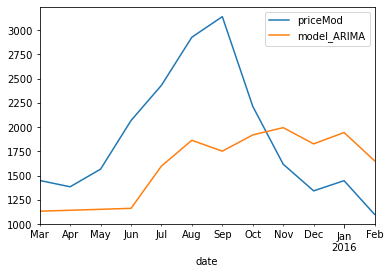

In [62]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_test.plot(kind = "line", x = "date", y = ['priceMod', 'model_ARIMA']);

Agregá el RMSE en el DataFrame de resultados:

In [63]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_Results.loc[1, "Model"] = "Log + Est + ARIMA"
df_Results.loc[1, "RMSE"] = RMSE(df_test['model_ARIMA'], df_test['priceMod'])
df_Results

,Model,RMSE
0,Log + Est,702.169
1,Log + Est + ARIMA,702.148
